# Predict DC Shared Bike Utilization Using Neural Network

- In this project, I investigated the dataset of DC shared bike system and weather information in DC area. The goal is to find out the factors which may affect the shared bike utilization and then predict the future utilization using neural network. 
- There are mainly three parts in this project. 1) data cleaning and aggregation; 2) data visualization and exploration; 3) prediction using neural network. 

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

C:\Users\Xin\Anaconda3\envs\keras\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Data Loading

In [2]:
# Fetch orginal data from a bunch of csv files in one location. We downloaded the bike usage data in 2016 and 2017 online. 
# The size of total data is ~ 1GB. (https://s3.amazonaws.com/capitalbikeshare-data/index.html)
# The data is organized on a quarterly base.

# Load one csv data file and get a sense of data type and content for bike usage information

data_dir = 'original_trip_data/2016Q1-capitalbikeshare-tripdata.csv'

df_sample = pd.read_csv(data_dir)
display(df_sample.head())

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,166,2016-01-01 00:06:58,2016-01-01 00:09:44,31102,11th & Kenyon St NW,31105,14th & Harvard St NW,W01346,Member
1,448,2016-01-01 00:10:20,2016-01-01 00:17:48,32039,Old Georgetown Rd & Southwick St,32002,Bethesda Ave & Arlington Rd,W22202,Member
2,715,2016-01-01 00:13:52,2016-01-01 00:25:48,31222,New York Ave & 15th St NW,31214,17th & Corcoran St NW,W21427,Member
3,213,2016-01-01 00:15:29,2016-01-01 00:19:03,31506,1st & Rhode Island Ave NW,31509,New Jersey Ave & R St NW,W01294,Member
4,872,2016-01-01 00:16:16,2016-01-01 00:30:49,31041,Prince St & Union St,31048,King St Metro South,W22058,Member


There are 9 columns in total in the file. We only need the information of 'Start date' and 'Member type' for further analysis. Thus, we can discard all other columns.

In [3]:
# Go through data files in the folder and load all the data files into one dataframe
file_dir = 'original_trip_data/'
count = 0

for file_name in os.listdir(file_dir):
    count += 1
    file_handler = open(file_dir + file_name, 'r')
    print(file_name)
    
    # Only colect two columns
    columns = ['Start date','Member type']
    df= pd.read_csv(file_handler, usecols=columns)
     
    if(count == 1): data = df
    else: data = pd.concat([data,df])
     
    file_handler.close()

2016Q1-capitalbikeshare-tripdata.csv
2016Q2-capitalbikeshare-tripdata.csv
2016Q3-capitalbikeshare-tripdata.csv
2016Q4-capitalbikeshare-tripdata.csv
2017Q1-capitalbikeshare-tripdata.csv
2017Q2-capitalbikeshare-tripdata.csv
2017Q3-capitalbikeshare-tripdata.csv
2017Q4-capitalbikeshare-tripdata.csv


In [4]:
# Check if the data is loaded correctly
display(data.head(6))

,Start date,Member type
0,2016-01-01 00:06:58,Member
1,2016-01-01 00:10:20,Member
2,2016-01-01 00:13:52,Member
3,2016-01-01 00:15:29,Member
4,2016-01-01 00:16:16,Member
5,2016-01-01 00:16:18,Casual


### Data Cleaning on Bike Dataset

In [5]:
# Seperate detailed date/time information from 'Start date' due to the complexity in the format

data['weekday'] = pd.DatetimeIndex(data['Start date']).weekday
data['quarter'] = pd.DatetimeIndex(data['Start date']).quarter
data['year'] = pd.DatetimeIndex(data['Start date']).year
data['month'] = pd.DatetimeIndex(data['Start date']).month
data['day'] = pd.DatetimeIndex(data['Start date']).day
data['hour'] = pd.DatetimeIndex(data['Start date']).hour

# Check the format after processing
display(data.head(6))

,Start date,Member type,weekday,quarter,year,month,day,hour
0,2016-01-01 00:06:58,Member,4,1,2016,1,1,0
1,2016-01-01 00:10:20,Member,4,1,2016,1,1,0
2,2016-01-01 00:13:52,Member,4,1,2016,1,1,0
3,2016-01-01 00:15:29,Member,4,1,2016,1,1,0
4,2016-01-01 00:16:16,Member,4,1,2016,1,1,0
5,2016-01-01 00:16:18,Casual,4,1,2016,1,1,0


In [6]:
# Seperate Member type into Member and Casual and aggregate data by Member type

dummies = pd.get_dummies(data['Member type'], drop_first=False)
data = pd.concat([data, dummies], axis=1)

data['casual'] = data.groupby(['year', 'month', 'day', 'hour'])['Casual'].transform('sum')
data['registered'] = data.groupby(['year', 'month', 'day', 'hour'])['Member'].transform('sum')

# Check the format after processing
display(data.head(6))

,Start date,Member type,weekday,quarter,year,month,day,hour,Casual,Member,casual,registered
0,2016-01-01 00:06:58,Member,4,1,2016,1,1,0,0,1,9.0,47.0
1,2016-01-01 00:10:20,Member,4,1,2016,1,1,0,0,1,9.0,47.0
2,2016-01-01 00:13:52,Member,4,1,2016,1,1,0,0,1,9.0,47.0
3,2016-01-01 00:15:29,Member,4,1,2016,1,1,0,0,1,9.0,47.0
4,2016-01-01 00:16:16,Member,4,1,2016,1,1,0,0,1,9.0,47.0
5,2016-01-01 00:16:18,Casual,4,1,2016,1,1,0,1,0,9.0,47.0


In [7]:
# Select the date(year-month-day) from 'Start data' 
data['dteday'] = data['Start date'].str[:10]

display(data.head(6))

,Start date,Member type,weekday,quarter,year,month,day,hour,Casual,Member,casual,registered,dteday
0,2016-01-01 00:06:58,Member,4,1,2016,1,1,0,0,1,9.0,47.0,2016-01-01
1,2016-01-01 00:10:20,Member,4,1,2016,1,1,0,0,1,9.0,47.0,2016-01-01
2,2016-01-01 00:13:52,Member,4,1,2016,1,1,0,0,1,9.0,47.0,2016-01-01
3,2016-01-01 00:15:29,Member,4,1,2016,1,1,0,0,1,9.0,47.0,2016-01-01
4,2016-01-01 00:16:16,Member,4,1,2016,1,1,0,0,1,9.0,47.0,2016-01-01
5,2016-01-01 00:16:18,Casual,4,1,2016,1,1,0,1,0,9.0,47.0,2016-01-01


In [8]:
# Drop out non-relevant columns and duplicates

df = data.drop(['Start date','Member type','Casual','Member'], axis=1)
print('The original dataframe contains ' + str(len(df)) + ' records.')

df.drop_duplicates(inplace = True)
df.reset_index(drop = True,inplace = True)

# Add the sum of casual and registered.
df['cnt'] = df.casual + df.registered

print('The final dataframe contains ' + str(len(df)) + ' records.')
display(df.head(6))

The original dataframe contains 7091771 records.
The final dataframe contains 17368 records.


,weekday,quarter,year,month,day,hour,casual,registered,dteday,cnt
0,4,1,2016,1,1,0,9.0,47.0,2016-01-01,56.0
1,4,1,2016,1,1,1,12.0,93.0,2016-01-01,105.0
2,4,1,2016,1,1,2,15.0,59.0,2016-01-01,74.0
3,4,1,2016,1,1,3,5.0,27.0,2016-01-01,32.0
4,4,1,2016,1,1,4,5.0,8.0,2016-01-01,13.0
5,4,1,2016,1,1,5,2.0,3.0,2016-01-01,5.0


In [9]:
# Get a list of holidays online. Need to include the holiday list in the dataframe.
holiday_list = ['2016-01-01', '2016-01-18', '2016-02-15', '2016-04-15', '2016-05-30', '2016-07-04',
               '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26','2017-01-02', 
                '2017-01-16', '2017-01-20', '2017-02-20', '2017-04-17', '2017-05-29', '2017-07-04',
               '2017-09-04', '2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']

display(holiday_list)

['2016-01-01',
 '2016-01-18',
 '2016-02-15',
 '2016-04-15',
 '2016-05-30',
 '2016-07-04',
 '2016-09-05',
 '2016-10-10',
 '2016-11-11',
 '2016-11-24',
 '2016-12-26',
 '2017-01-02',
 '2017-01-16',
 '2017-01-20',
 '2017-02-20',
 '2017-04-17',
 '2017-05-29',
 '2017-07-04',
 '2017-09-04',
 '2017-10-09',
 '2017-11-10',
 '2017-11-23',
 '2017-12-25']

In [10]:
# Add a new column 'holiday' to label whether it is holiday or not for a given date

df['holiday'] = df.dteday.isin(holiday_list).astype(int)

display(df.head(6))

,weekday,quarter,year,month,day,hour,casual,registered,dteday,cnt,holiday
0,4,1,2016,1,1,0,9.0,47.0,2016-01-01,56.0,1
1,4,1,2016,1,1,1,12.0,93.0,2016-01-01,105.0,1
2,4,1,2016,1,1,2,15.0,59.0,2016-01-01,74.0,1
3,4,1,2016,1,1,3,5.0,27.0,2016-01-01,32.0,1
4,4,1,2016,1,1,4,5.0,8.0,2016-01-01,13.0,1
5,4,1,2016,1,1,5,2.0,3.0,2016-01-01,5.0,1


In [11]:
# Check if holidays have been labeled correctly. Choose New Year Day as an example.

print(df.loc[0,'dteday'])
print(holiday_list[0])

df.loc[0,'dteday'] in holiday_list

2016-01-01
2016-01-01


True

In [12]:
# Check the inputs of date/time information to make sure they contain correct information. 

print('year:\t%s' %df.year.unique())
print('\n')
print('quarter:\t%s' %sorted(df.quarter.unique()))
print('\n')
print('month:\t%s' %sorted(df.month.unique()))
print('\n')
print('day:\t%s' %sorted(df.day.unique()))
print('\n')
print('weekday:\t%s' %sorted(df.weekday.unique()))
print('\n')
print('hour:\t%s' %sorted(df.hour.unique()))
print('\n')

year:	[2016 2017]


quarter:	[1, 2, 3, 4]


month:	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


day:	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


weekday:	[0, 1, 2, 3, 4, 5, 6]


hour:	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]




### Data Cleaning on Weather Dataset

In [13]:
# Data cleaning on weather data. 
'''
Abbreviation in weather dataset:  USAF = AIR FORCE CATALOG STATION NUMBER; SPD = WIND SPEED; 
CLG = CLOUD CEILING--LOWEST OPAQUE LAYER; TEMP & DEWP = TEMPERATURE & DEW POINT IN FAHRENHEIT; 
SLP = SEA LEVEL PRESSURE IN MILLIBARS
'''

weather = pd.read_csv('DC_weather_2016_2017.txt', delim_whitespace=True,
                   usecols = ['USAF', 'YR--MODAHRMN', 'SPD', 'CLG', 'TEMP', 'DEWP', 'SLP'])

weather = weather[weather['USAF'] == 724050]

display(weather.head(8))

print(weather.shape)

C:\Users\Xin\Anaconda3\envs\keras\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,USAF,YR--MODAHRMN,SPD,CLG,TEMP,DEWP,SLP
0,724050,201601010452,11,44,45,32,1021.5
1,724050,201601010459,***,***,****,****,******
2,724050,201601010552,8,46,44,32,1021.1
3,724050,201601010600,8,***,44,32,1021.1
4,724050,201601010652,7,230,42,32,1020.8
5,724050,201601010752,8,220,42,32,1021.1
6,724050,201601010852,7,220,42,30,1020.7
7,724050,201601010900,7,***,42,30,1020.7


(28884, 7)


Missing data points in the weather information need to be handled.

In [14]:
# Data cleaning for weather data (replace **** with NaN)

weather = weather.replace(['***','****','******'],np.nan)

In [15]:
# Check data type of weather information.

weather.dtypes

USAF             int64
YR--MODAHRMN     int64
SPD             object
CLG             object
TEMP            object
DEWP            object
SLP             object
dtype: object

In [16]:
# Calculate percentages of missing data in weather dataset

print('Percentage of missing data for TEMP: ', len(weather[weather['TEMP'].isna()])*1.0/len(weather))
print('Percentage of missing data for SLP: ', len(weather[weather['SLP'].isna()])*1.0/len(weather))
print('Percentage of missing data for SPD: ', len(weather[weather['SPD'].isna()])*1.0/len(weather))
print('Percentage of missing data for CLG: ', len(weather[weather['CLG'].isna()])*1.0/len(weather))
print('Percentage of missing data for DEWP: ', len(weather[weather['DEWP'].isna()])*1.0/len(weather))

Percentage of missing data for TEMP:  0.025619720260351753
Percentage of missing data for SLP:  0.19398282786317683
Percentage of missing data for SPD:  0.02596593269630245
Percentage of missing data for CLG:  0.20173798642847252
Percentage of missing data for DEWP:  0.025654341503946822


In [17]:
# Fill the missing data with the data point in the last hour.

weather.fillna(method='ffill', inplace=True)

In [18]:
# Check if all the missing data points are filled out.

print('Percentage of missing data for TEMP: ', len(weather[weather['TEMP'].isna()])*1.0/len(data))
print('Percentage of missing data for SLP: ', len(weather[weather['SLP'].isna()])*1.0/len(data))

Percentage of missing data for TEMP:  0.0
Percentage of missing data for SLP:  0.0


No missing data points in weather dataset

In [19]:
# Date/time format conversion

weather['time'] = pd.DatetimeIndex(weather['YR--MODAHRMN'].astype(str))

# convert GMT time to DC time
weather['time_adjust'] = weather['time'] - np.timedelta64(4, 'h')

display(weather.head(5))

,USAF,YR--MODAHRMN,SPD,CLG,TEMP,DEWP,SLP,time,time_adjust
0,724050,201601010452,11,44,45,32,1021.5,2016-01-01 04:52:00,2016-01-01 00:52:00
1,724050,201601010459,11,44,45,32,1021.5,2016-01-01 04:59:00,2016-01-01 00:59:00
2,724050,201601010552,8,46,44,32,1021.1,2016-01-01 05:52:00,2016-01-01 01:52:00
3,724050,201601010600,8,46,44,32,1021.1,2016-01-01 06:00:00,2016-01-01 02:00:00
4,724050,201601010652,7,230,42,32,1020.8,2016-01-01 06:52:00,2016-01-01 02:52:00


In [20]:
# Separate date/time information from weather

weather['year'] = pd.DatetimeIndex(weather['time_adjust']).year
weather['month'] = pd.DatetimeIndex(weather['time_adjust']).month
weather['day'] = pd.DatetimeIndex(weather['time_adjust']).day
weather['hour'] = pd.DatetimeIndex(weather['time_adjust']).hour

display(weather.head(5))

,USAF,YR--MODAHRMN,SPD,CLG,TEMP,DEWP,SLP,time,time_adjust,year,month,day,hour
0,724050,201601010452,11,44,45,32,1021.5,2016-01-01 04:52:00,2016-01-01 00:52:00,2016,1,1,0
1,724050,201601010459,11,44,45,32,1021.5,2016-01-01 04:59:00,2016-01-01 00:59:00,2016,1,1,0
2,724050,201601010552,8,46,44,32,1021.1,2016-01-01 05:52:00,2016-01-01 01:52:00,2016,1,1,1
3,724050,201601010600,8,46,44,32,1021.1,2016-01-01 06:00:00,2016-01-01 02:00:00,2016,1,1,2
4,724050,201601010652,7,230,42,32,1020.8,2016-01-01 06:52:00,2016-01-01 02:52:00,2016,1,1,2


In [21]:
# Drop out unrelavent columns 

dfw = weather.drop(['USAF', 'YR--MODAHRMN','time','time_adjust'], axis = 1)
print('Dataframe size:', len(dfw))
display(dfw.head(5))

# Remove duplicates with same year, month, day and hour
dfw.drop_duplicates(subset=['year','month','day','hour'],inplace = True)
dfw.reset_index(drop = True,inplace = True)
print('Adjusted dataframe size:', len(dfw))
display(dfw.head(5))

Dataframe size: 28884


,SPD,CLG,TEMP,DEWP,SLP,year,month,day,hour
0,11,44,45,32,1021.5,2016,1,1,0
1,11,44,45,32,1021.5,2016,1,1,0
2,8,46,44,32,1021.1,2016,1,1,1
3,8,46,44,32,1021.1,2016,1,1,2
4,7,230,42,32,1020.8,2016,1,1,2


Adjusted dataframe size: 17543


,SPD,CLG,TEMP,DEWP,SLP,year,month,day,hour
0,11,44,45,32,1021.5,2016,1,1,0
1,8,46,44,32,1021.1,2016,1,1,1
2,8,46,44,32,1021.1,2016,1,1,2
3,8,220,42,32,1021.1,2016,1,1,3
4,7,220,42,30,1020.7,2016,1,1,4


In [22]:
# Check data type of weather df.
dfw.dtypes

SPD      object
CLG      object
TEMP     object
DEWP     object
SLP      object
year      int64
month     int64
day       int64
hour      int64
dtype: object

In [23]:
# Convert the data type of weather from string to int

dfw['TEMP'] = dfw['TEMP'].astype(str).astype(int)
dfw['DEWP'] = dfw['DEWP'].astype(str).astype(int)
dfw['SPD'] = dfw['SPD'].astype(str).astype(int)
dfw['CLG'] = dfw['CLG'].astype(str).astype(int)
dfw['SLP'] = dfw['SLP'].astype(str).astype(float)

display(dfw.describe())

,SPD,CLG,TEMP,DEWP,SLP,year,month,day,hour
count,17543.000000,17543.000000,17543.000000,17543.000000,17543.000000,17543.000000,17543.000000,17543.000000,17543.000000
mean,8.760303,346.243288,60.213133,47.031865,1017.605204,2016.499458,6.519181,15.738984,11.499344
std,5.078099,300.648845,17.622306,19.241445,7.303464,0.500128,3.449749,8.804454,6.922218
min,0.000000,0.000000,13.000000,-9.000000,988.000000,2016.000000,1.000000,1.000000,0.000000
25%,6.000000,65.000000,47.000000,33.000000,1013.200000,2016.000000,4.000000,8.000000,5.500000
50%,8.000000,250.000000,61.000000,50.000000,1017.400000,2016.000000,7.000000,16.000000,11.000000
75%,11.000000,722.000000,75.000000,64.000000,1022.100000,2017.000000,10.000000,23.000000,17.000000
max,52.000000,722.000000,100.000000,80.000000,1043.000000,2018.000000,12.000000,31.000000,23.000000


In [24]:
display(dfw.head(5))

,SPD,CLG,TEMP,DEWP,SLP,year,month,day,hour
0,11,44,45,32,1021.5,2016,1,1,0
1,8,46,44,32,1021.1,2016,1,1,1
2,8,46,44,32,1021.1,2016,1,1,2
3,8,220,42,32,1021.1,2016,1,1,3
4,7,220,42,30,1020.7,2016,1,1,4


In [25]:
# Check the date/time information to make sure they contain correct information. 

print('year:\t%s' %dfw.year.unique())
print('\n')
print('month:\t%s' %sorted(dfw.month.unique()))
print('\n')
print('day:\t%s' %sorted(dfw.day.unique()))
print('\n')
print('hour:\t%s' %sorted(dfw.hour.unique()))
print('\n')

year:	[2016 2017 2018]


month:	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


day:	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


hour:	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]




In [26]:
# Compare the record numbers of bike sharing and weather dataframes 

print('Number of records in the bike sharing dataframe:\t%s' %len(df))
print('Number of records in the weather dataframe:\t%s' %len(dfw))

Number of records in the bike sharing dataframe:	17368
Number of records in the weather dataframe:	17543


In [27]:
# Check data type in bike sharing and weather dataframes

display(df.dtypes)
display(dfw.dtypes)

weekday         int64
quarter         int64
year            int64
month           int64
day             int64
hour            int64
casual        float64
registered    float64
dteday         object
cnt           float64
holiday         int32
dtype: object

SPD        int32
CLG        int32
TEMP       int32
DEWP       int32
SLP      float64
year       int64
month      int64
day        int64
hour       int64
dtype: object

## Data Merge

In [28]:
# Combine two dataframes aligned with date/time

df_combine = pd.merge(df, dfw, how='left', on=['year','month','day','hour'])

df_combine.head()

,weekday,quarter,year,month,day,hour,casual,registered,dteday,cnt,holiday,SPD,CLG,TEMP,DEWP,SLP
0,4,1,2016,1,1,0,9.0,47.0,2016-01-01,56.0,1,11.0,44.0,45.0,32.0,1021.5
1,4,1,2016,1,1,1,12.0,93.0,2016-01-01,105.0,1,8.0,46.0,44.0,32.0,1021.1
2,4,1,2016,1,1,2,15.0,59.0,2016-01-01,74.0,1,8.0,46.0,44.0,32.0,1021.1
3,4,1,2016,1,1,3,5.0,27.0,2016-01-01,32.0,1,8.0,220.0,42.0,32.0,1021.1
4,4,1,2016,1,1,4,5.0,8.0,2016-01-01,13.0,1,7.0,220.0,42.0,30.0,1020.7


In [29]:
print('Number of records in combined dataframe: ', len(df_combine))

Number of records in combined dataframe:  17368


In [30]:
display(df_combine.describe())

,weekday,quarter,year,month,day,hour,casual,registered,cnt,holiday,SPD,CLG,TEMP,DEWP,SLP
count,17368.000000,17368.000000,17368.000000,17368.000000,17368.000000,17368.000000,17368.000000,17368.000000,17368.000000,17368.000000,17366.000000,17366.000000,17366.000000,17366.000000,17366.000000
mean,3.011861,2.520555,2016.503052,6.565523,15.677395,11.530804,98.693977,309.630009,408.323987,0.031725,8.746574,347.117241,60.480191,47.255442,1017.607238
std,1.998208,1.113025,0.500005,3.426611,8.801102,6.915407,134.302630,309.954471,390.763603,0.175272,5.048533,300.691657,17.481104,19.176070,7.294531
min,0.000000,1.000000,2016.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,13.000000,-9.000000,988.000000
25%,1.000000,2.000000,2016.000000,4.000000,8.000000,6.000000,8.000000,62.000000,77.000000,0.000000,6.000000,65.000000,47.000000,33.000000,1013.200000
50%,3.000000,3.000000,2017.000000,7.000000,16.000000,12.000000,42.000000,238.000000,312.000000,0.000000,8.000000,250.000000,61.000000,50.000000,1017.400000
75%,5.000000,4.000000,2017.000000,10.000000,23.000000,18.000000,142.000000,436.000000,611.000000,0.000000,11.000000,722.000000,75.000000,64.000000,1022.100000
max,6.000000,4.000000,2017.000000,12.000000,31.000000,23.000000,1037.000000,1639.000000,1988.000000,1.000000,52.000000,722.000000,100.000000,80.000000,1043.000000


In [31]:
# Check if there is any missing data in the combined dataframe.

print(df_combine.isnull().values.any())
print(df.isnull().values.any())
print(dfw.isnull().values.any())

True
False
False


In [32]:
# Check data types in the combined dataframe

df_combine.dtypes


weekday         int64
quarter         int64
year            int64
month           int64
day             int64
hour            int64
casual        float64
registered    float64
dteday         object
cnt           float64
holiday         int32
SPD           float64
CLG           float64
TEMP          float64
DEWP          float64
SLP           float64
dtype: object

In [33]:
display(df_combine.head(6))

,weekday,quarter,year,month,day,hour,casual,registered,dteday,cnt,holiday,SPD,CLG,TEMP,DEWP,SLP
0,4,1,2016,1,1,0,9.0,47.0,2016-01-01,56.0,1,11.0,44.0,45.0,32.0,1021.5
1,4,1,2016,1,1,1,12.0,93.0,2016-01-01,105.0,1,8.0,46.0,44.0,32.0,1021.1
2,4,1,2016,1,1,2,15.0,59.0,2016-01-01,74.0,1,8.0,46.0,44.0,32.0,1021.1
3,4,1,2016,1,1,3,5.0,27.0,2016-01-01,32.0,1,8.0,220.0,42.0,32.0,1021.1
4,4,1,2016,1,1,4,5.0,8.0,2016-01-01,13.0,1,7.0,220.0,42.0,30.0,1020.7
5,4,1,2016,1,1,5,2.0,3.0,2016-01-01,5.0,1,7.0,220.0,42.0,30.0,1020.7


In [34]:
# Fill out the missing datapoints

df_combine.fillna(method='ffill', inplace=True)
print(df_combine.isnull().values.any())

False


In [35]:
# Save the combined dataframe into a csv file

df_combine.to_csv('hour_new.csv', index = False)

## Data Exploration

Now we want to explore the correlations between a variety of variables which may affect the shared bike utilization.

Text(0.5,0,'Shared Bike Utilization Count')

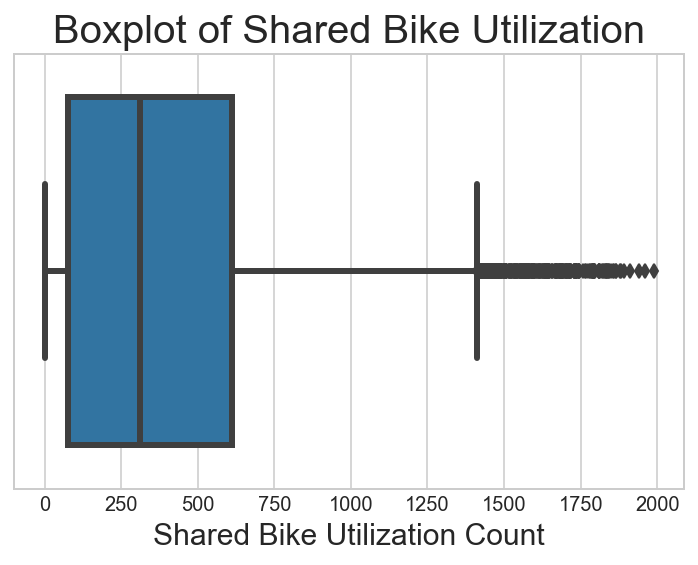

In [36]:
# First, let's take a look at the distribution of count.

rides = df_combine
sns.set_style('whitegrid')
ax = sns.boxplot(y = rides.cnt, orient = 'h', linewidth = 3)
ax.axes.set_title('Boxplot of Shared Bike Utilization', fontsize = 20)
ax.set_xlabel('Shared Bike Utilization Count', fontsize = 15)

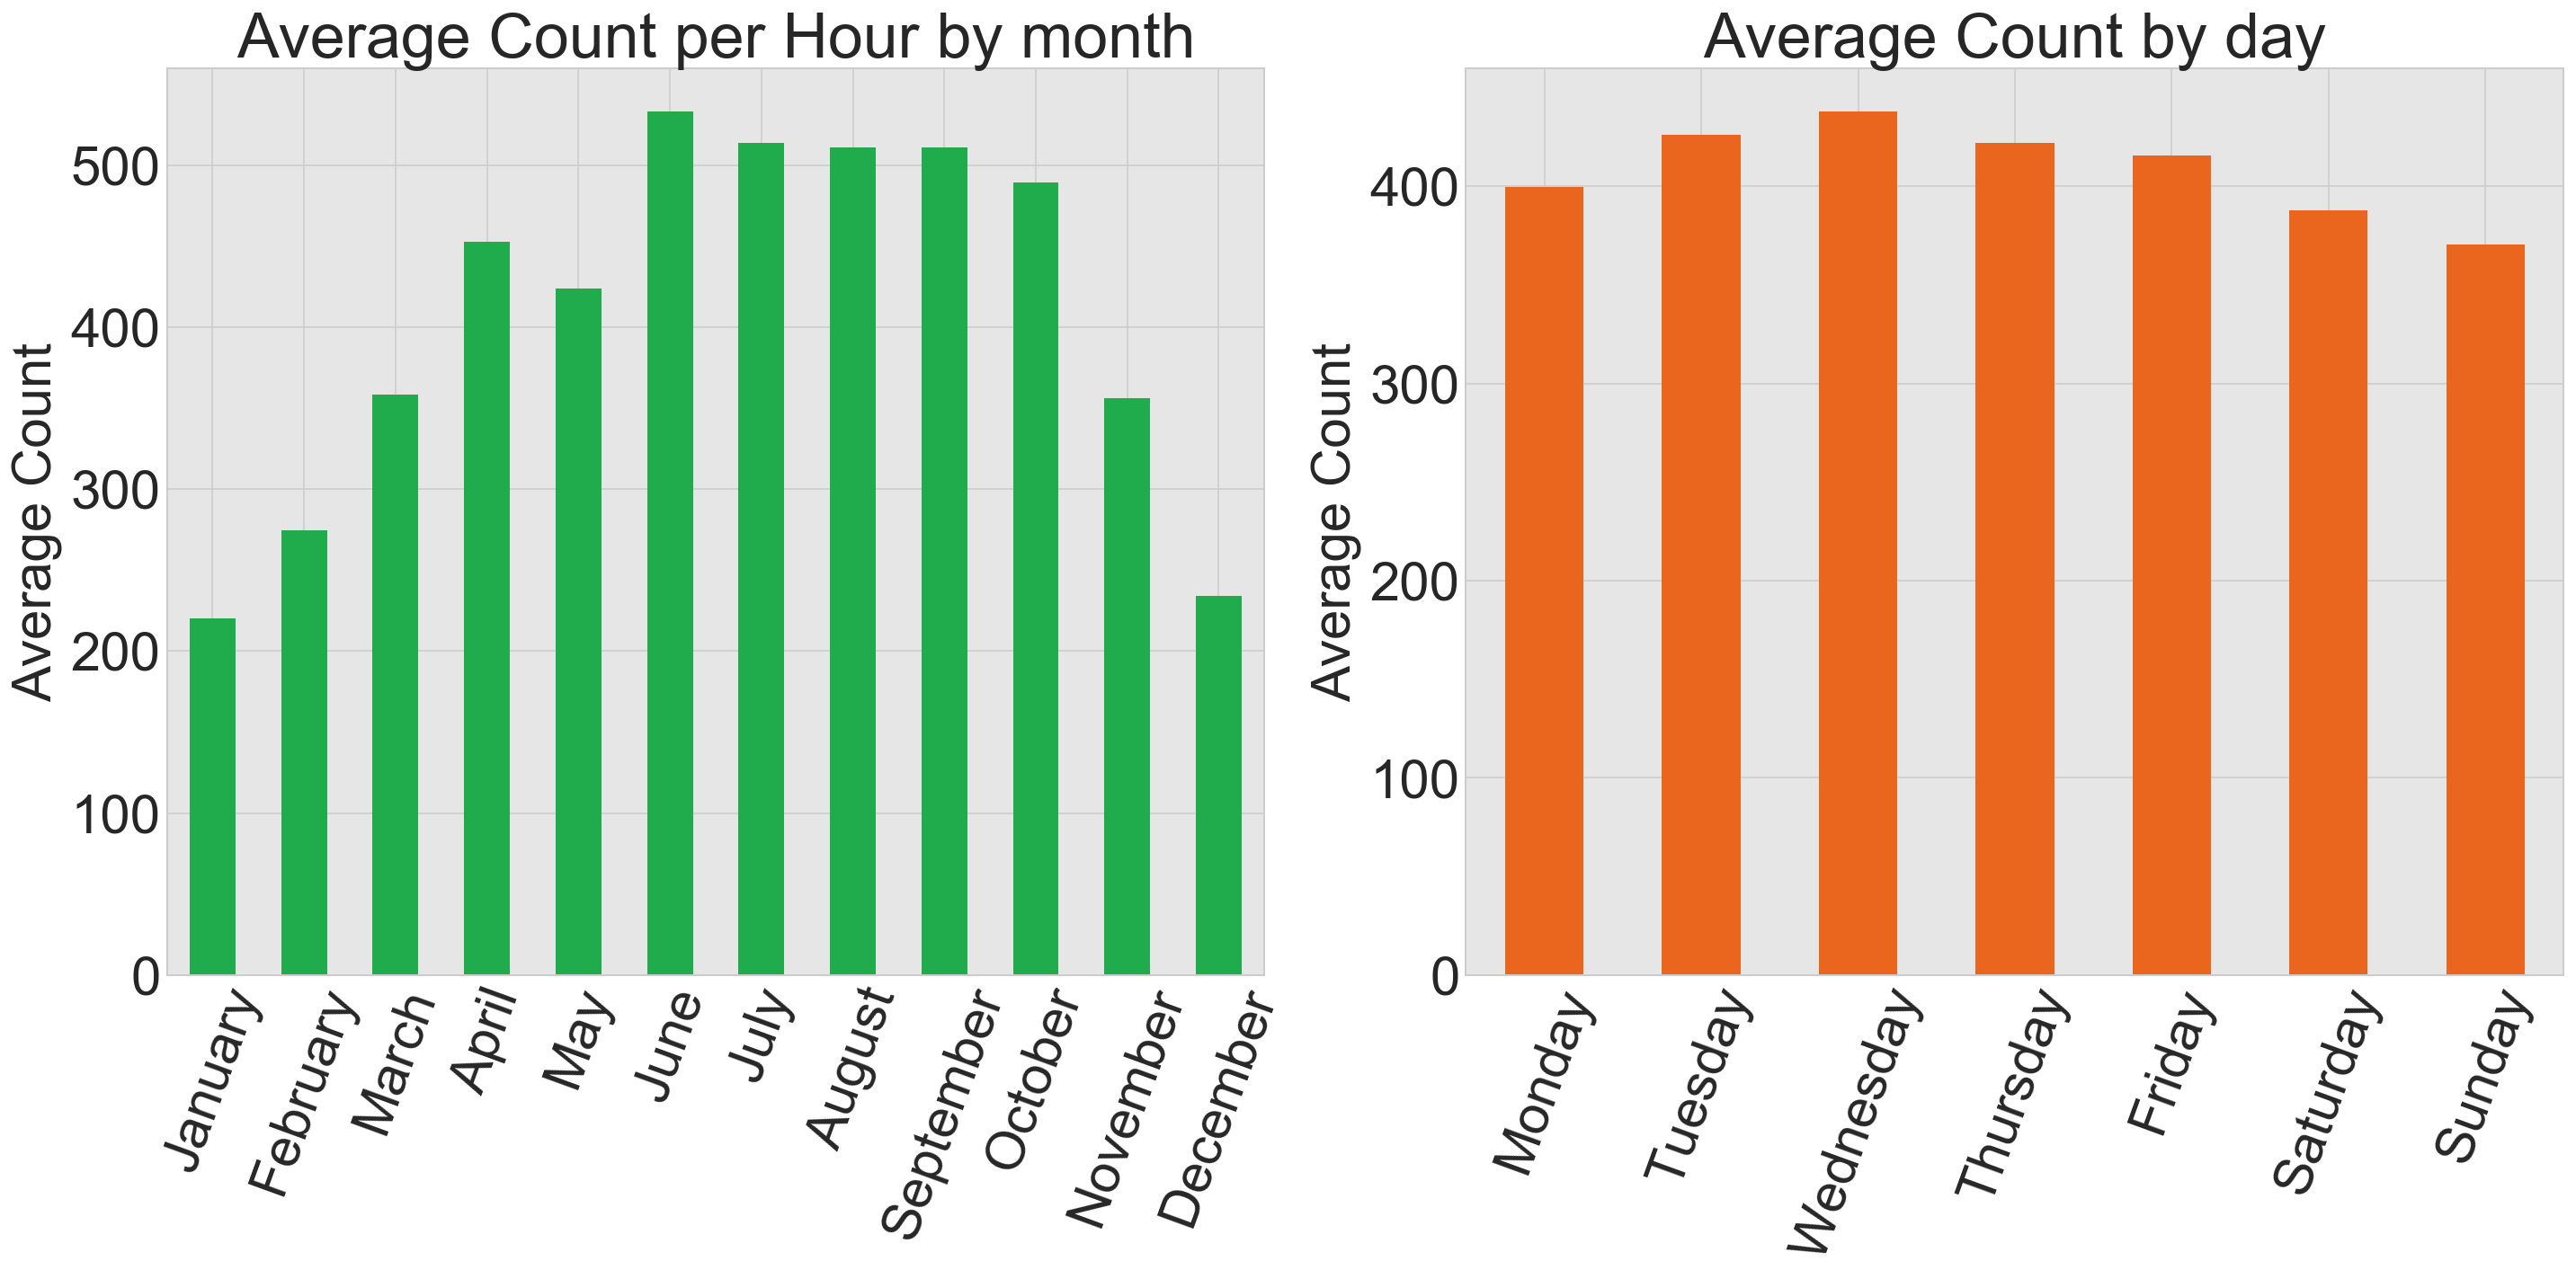

In [37]:
# Then we want to study the monthly and weekday shared bike utilization.

# Monthly & daily utilization

cnt_by_month = rides.groupby('month')['cnt'].mean()
cnt_by_month.index = ["January","February","March","April","May","June","July",
                   "August","September","October","November","December"]

cnt_by_day = rides.groupby('weekday')['cnt'].mean()
cnt_by_day.index = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

fig = plt.figure(figsize = (11,5))
ax1 = fig.add_subplot(1, 2, 1)
cnt_by_month.plot(kind = 'bar', color = '#20AB4C')
ax1.set_facecolor('0.9')
ax1.set_xticklabels(cnt_by_month.index, rotation=70, fontsize=30)
ax1.set_yticklabels([0, 100, 200, 300, 400, 500], fontsize=30)
ax1.set_ylabel('Average Count', fontsize=30)
ax1.set_title('Average Count per Hour by month', fontsize = 35)
fig.set_size_inches(20,10)

ax2 = fig.add_subplot(1, 2, 2)
cnt_by_day.plot(kind = 'bar', color = '#EA651D')
ax2.set_facecolor('0.9')
ax2.set_xticklabels(cnt_by_day.index, rotation=70, fontsize=30)
ax2.set_yticklabels([0, 100, 200, 300, 400], fontsize=30)
ax2.set_ylabel('Average Count', fontsize=30)
ax2.set_title('Average Count by day', fontsize = 35)

plt.tight_layout()
plt.show()


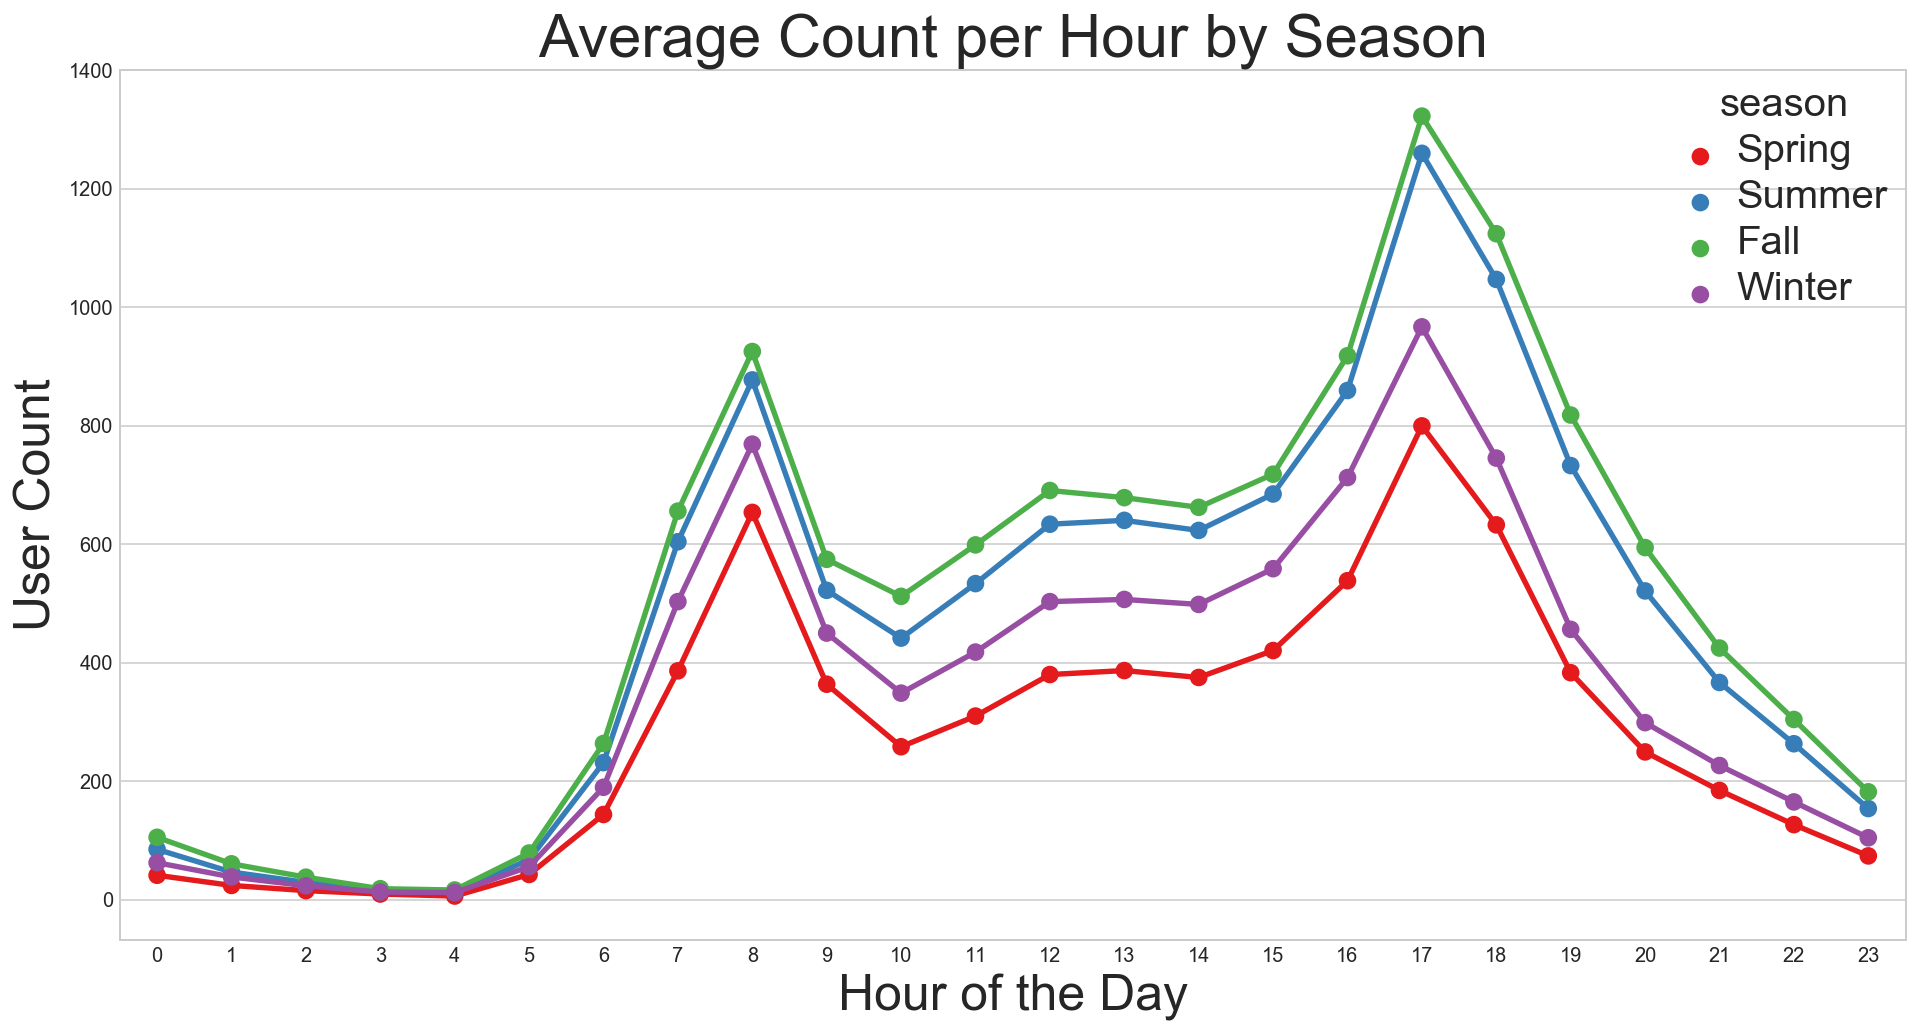

In [38]:
# Hourly utilization for different seasons

cnt_by_hour_quarter = pd.DataFrame(rides.groupby(['hour','quarter'])['cnt'].mean()).reset_index()
cnt_by_hour_quarter['season'] = cnt_by_hour_quarter.quarter.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })

plt.figure(figsize=(16,8))
ax = sns.pointplot(x=cnt_by_hour_quarter["hour"], y=cnt_by_hour_quarter["cnt"],
         hue=cnt_by_hour_quarter["season"], data=cnt_by_hour_quarter, palette = 'Set1')
ax.set_title('Average Count per Hour by Season',fontsize = 30)
ax.set_xlabel('Hour of the Day',fontsize = 25)
ax.set_ylabel('User Count',fontsize = 25)

plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title

plt.show()

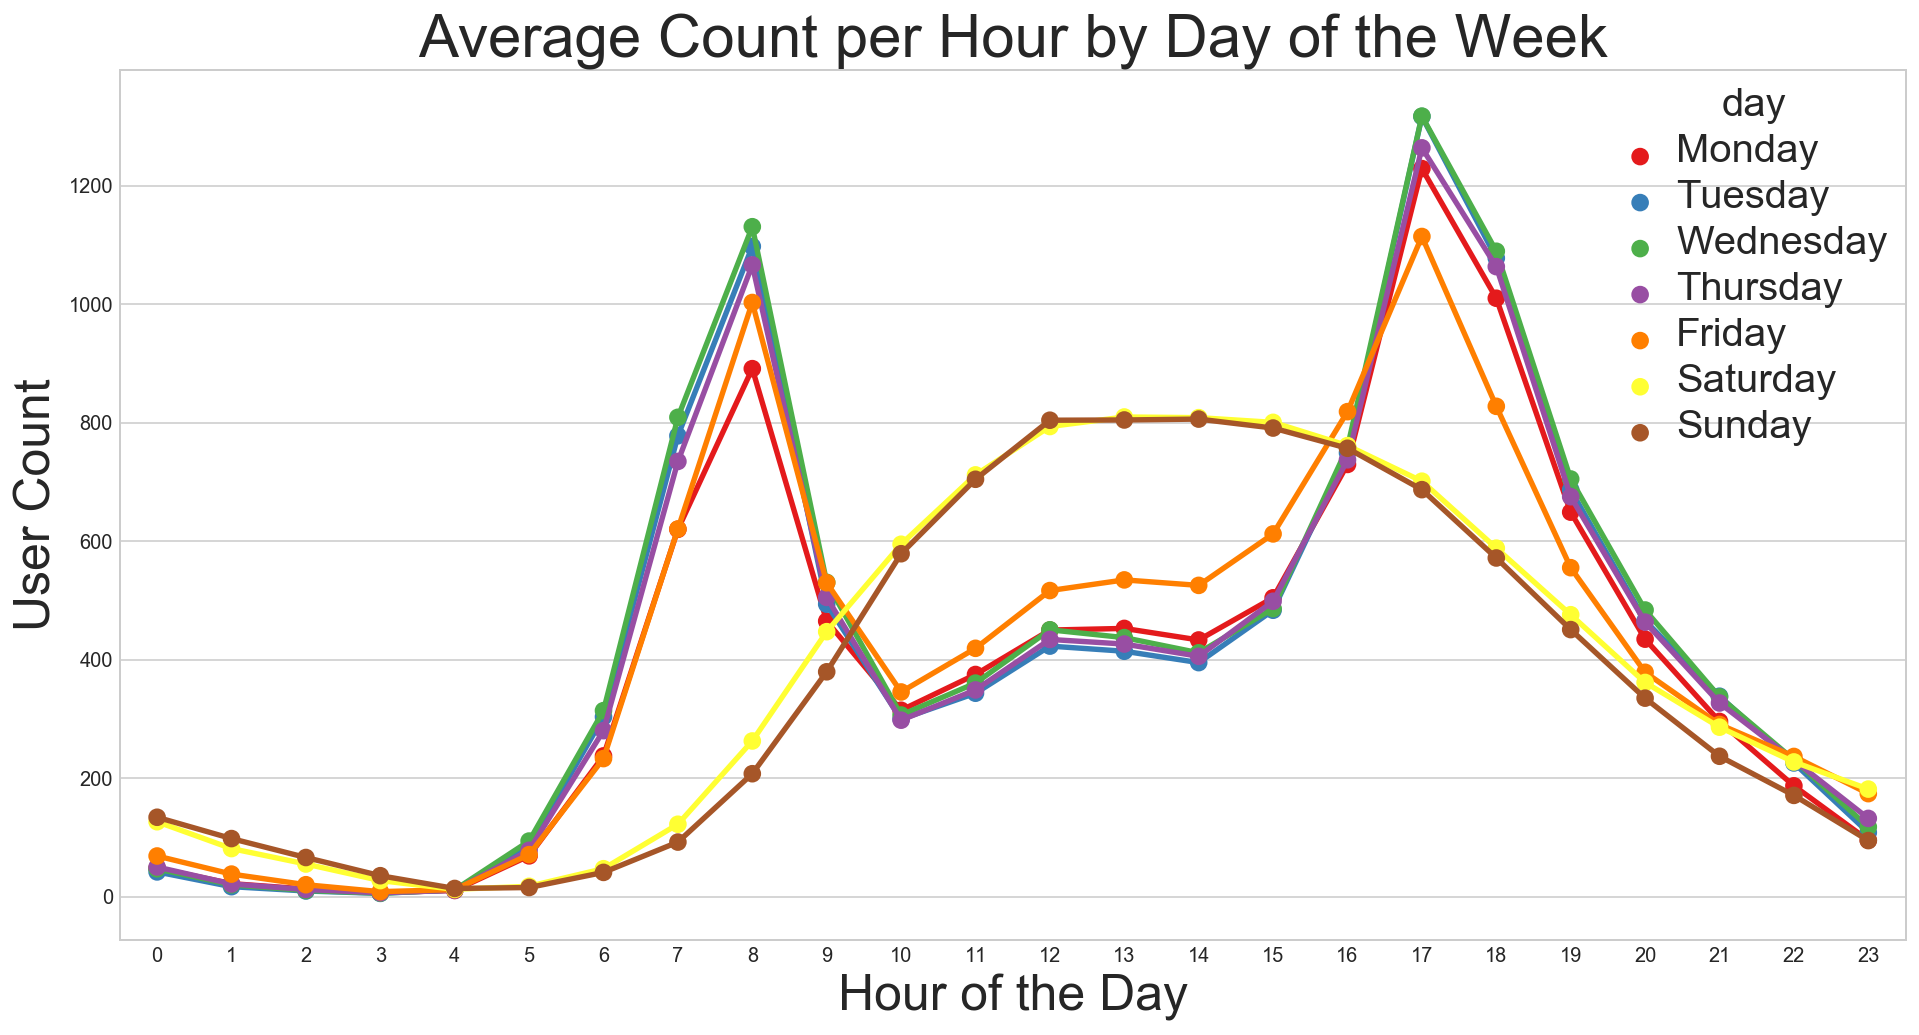

In [39]:
# Hourly utilization for different days in a week

cnt_by_hour_weekday = pd.DataFrame(rides.groupby(['hour','weekday'])['cnt'].mean()).reset_index()
cnt_by_hour_weekday['day'] = cnt_by_hour_weekday.weekday.map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                                                                 4:'Friday',5:'Saturday',6:'Sunday'})

plt.figure(figsize=(16,8))
ax = sns.pointplot(x="hour", y="cnt",hue="day", data=cnt_by_hour_weekday, palette = 'Set1')
ax.set_title('Average Count per Hour by Day of the Week',fontsize = 30)
ax.set_xlabel('Hour of the Day',fontsize = 25)
ax.set_ylabel('User Count',fontsize = 25)

plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title

plt.show()

In [40]:
# Now let's turn our attention to registered and casual users on a hourly base in a day.

cnt_by_hour_user = pd.DataFrame(rides.groupby(['hour'])['casual','registered'].mean()).reset_index()
melted = pd.melt(cnt_by_hour_user, id_vars=['hour'], var_name='user type', value_name='count')

print(melted)

    hour   user type       count
0      0      casual   21.088276
1      1      casual   12.757576
2      2      casual    7.722067
3      3      casual    4.096491
4      4      casual    2.270833
5      5      casual    4.179310
6      6      casual   11.201102
7      7      casual   28.696970
8      8      casual   56.938017
9      9      casual   88.077135
10    10      casual  132.622590
11    11      casual  169.695592
12    12      casual  192.177686
13    13      casual  203.877410
14    14      casual  215.303030
15    15      casual  215.325997
16    16      casual  212.515818
17    17      casual  214.077029
18    18      casual  169.211829
19    19      casual  132.319559
20    20      casual  100.446281
21    21      casual   75.775482
22    22      casual   56.165289
23    23      casual   33.780992
24     0  registered   52.586207
25     1  registered   29.663912
26     2  registered   18.822626
27     3  registered    9.868421
28     4  registered    9.312500
29     5  

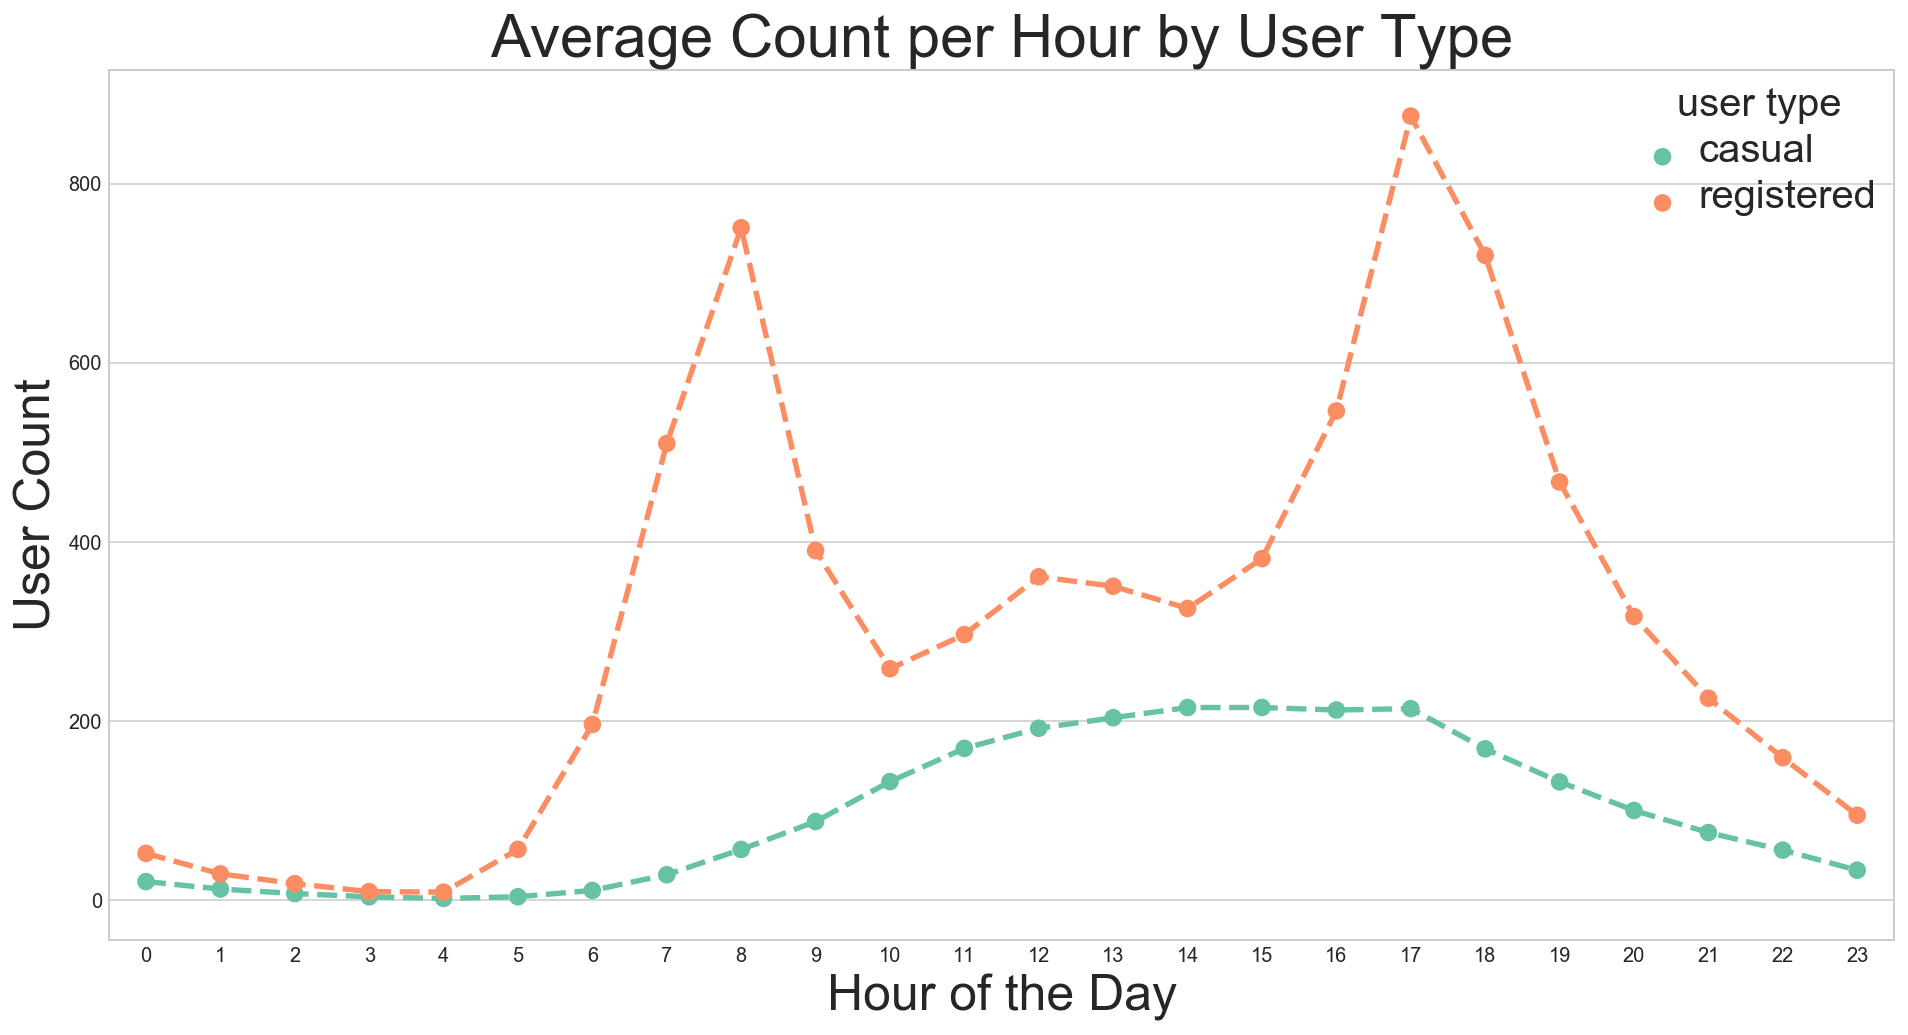

In [41]:
cnt_by_hour_user = pd.DataFrame(rides.groupby(['hour'])['casual','registered'].mean()).reset_index()
melted = pd.melt(cnt_by_hour_user, id_vars=['hour'], var_name='user type', value_name='count')

plt.figure(figsize=(16,8))

ax = sns.pointplot(x='hour', y='count',hue='user type', linestyles = '--', data=melted, palette = 'Set2')
ax.set_title('Average Count per Hour by User Type',fontsize = 30)
ax.set_xlabel('Hour of the Day',fontsize = 25)
ax.set_ylabel('User Count',fontsize = 25)

plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title

plt.show()

C:\Users\Xin\Anaconda3\envs\keras\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


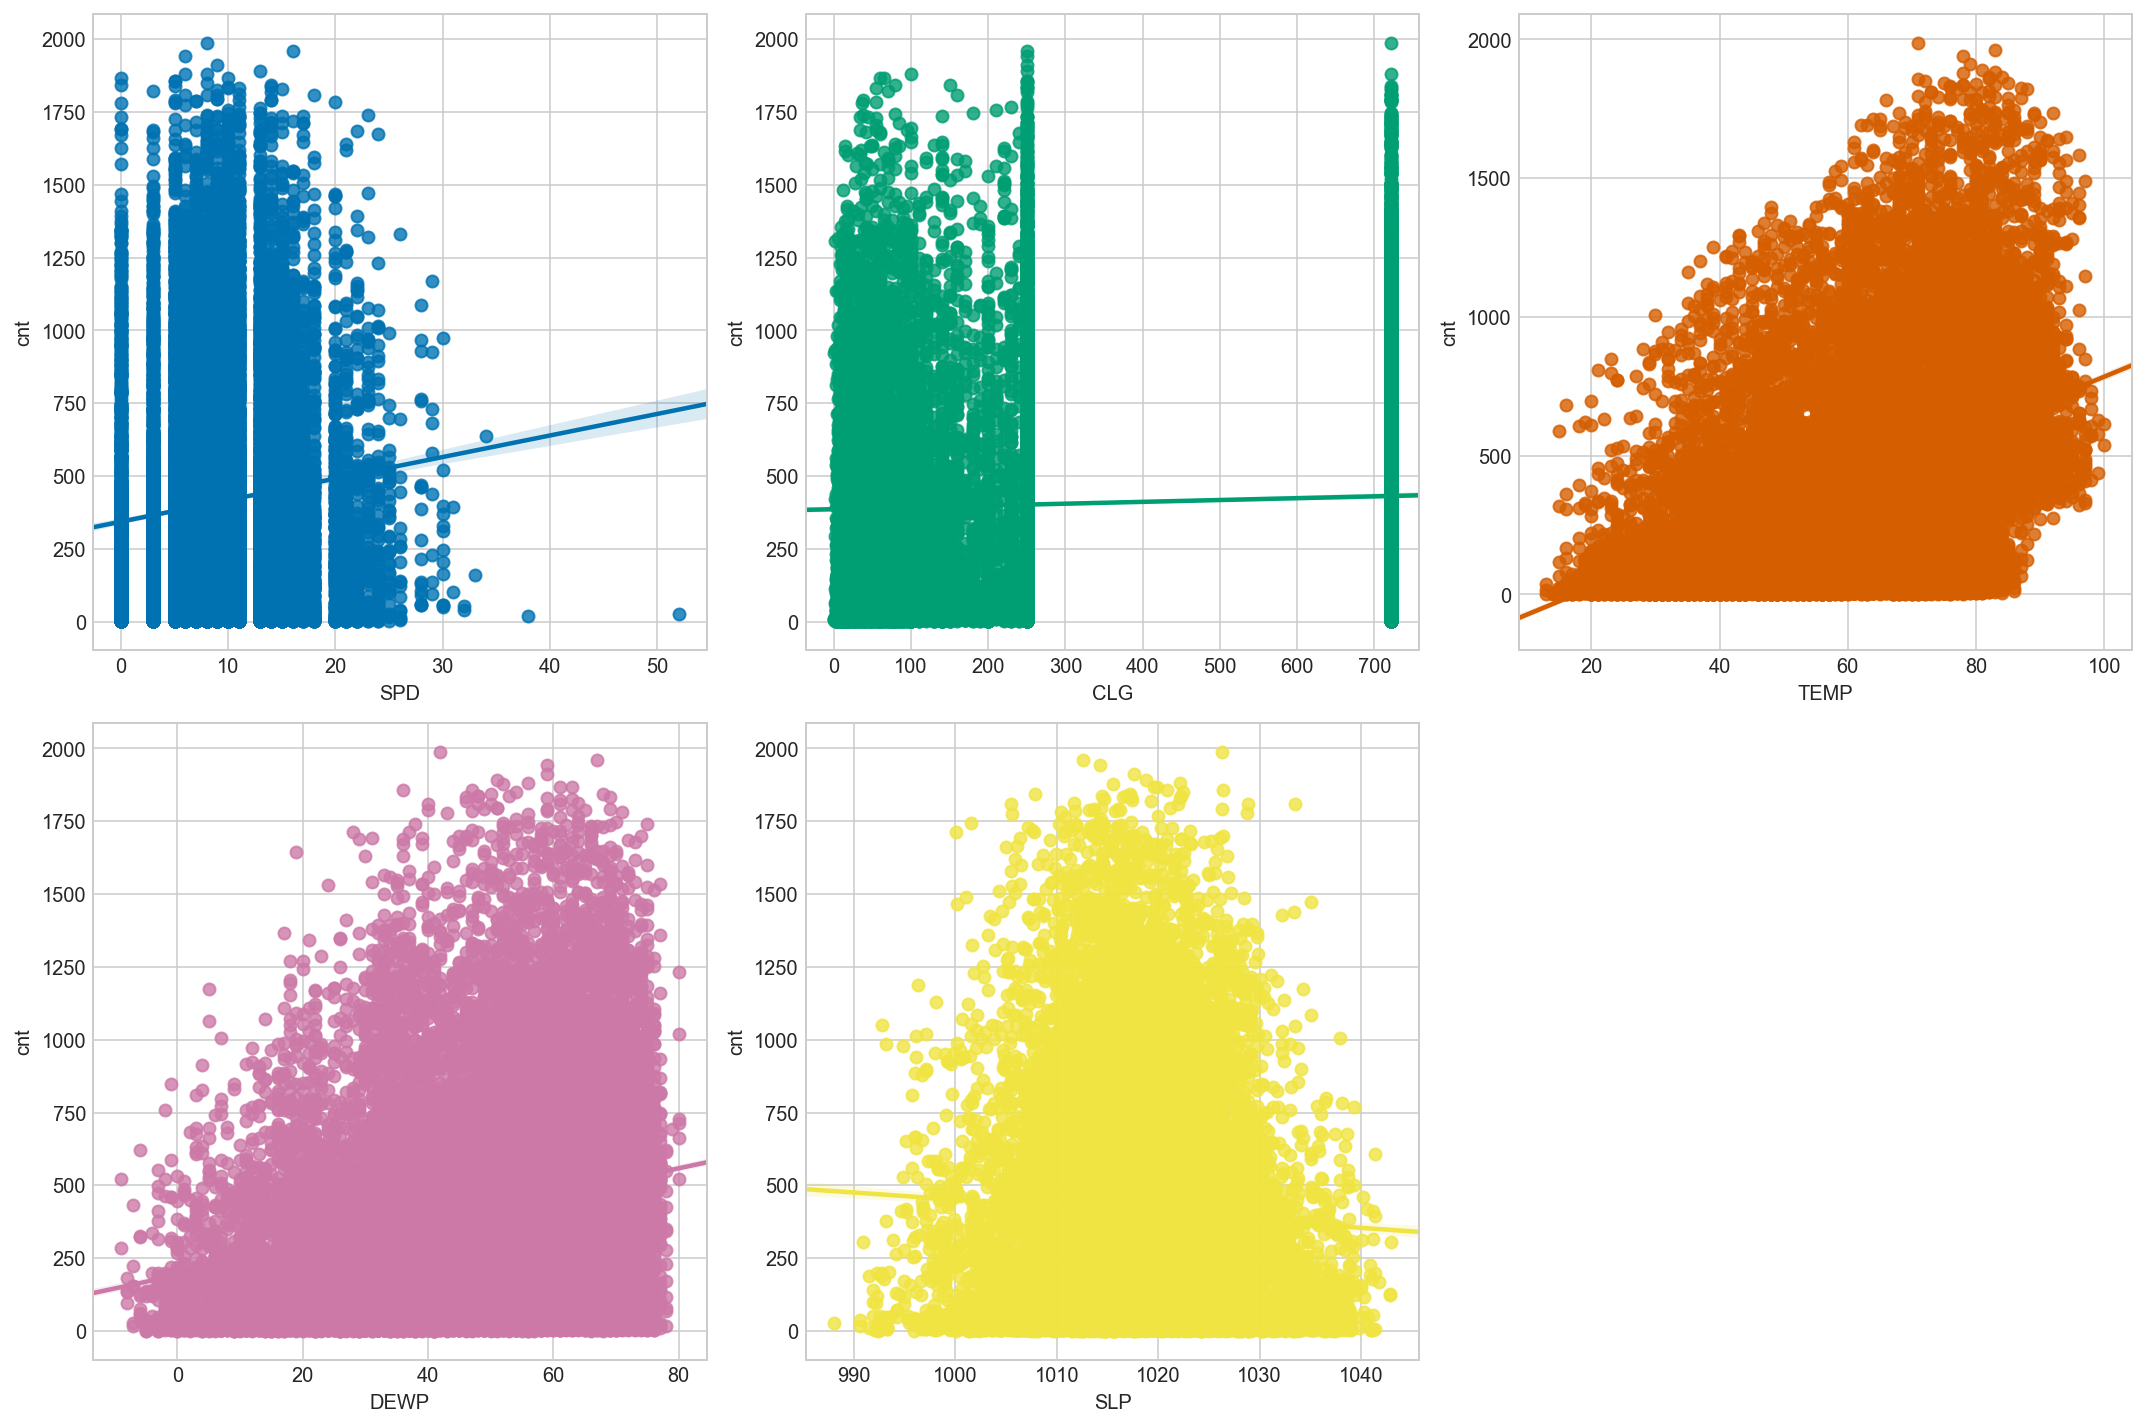

In [42]:
# Next, we want to investigate the correlation between count and weather 
# parameters one by one.

current_palette = sns.color_palette('colorblind')

fig = plt.figure(figsize = (15,10))

for i, feature in enumerate(['SPD', 'CLG', 'TEMP', 'DEWP', 'SLP']):
    ax = fig.add_subplot(2, 3, i+1)
    ax = sns.regplot(x=feature, y="cnt", data=rides, color = current_palette[i])

fig.tight_layout()
fig.show()

Text(0.5,1,'Correlation Heatmap')

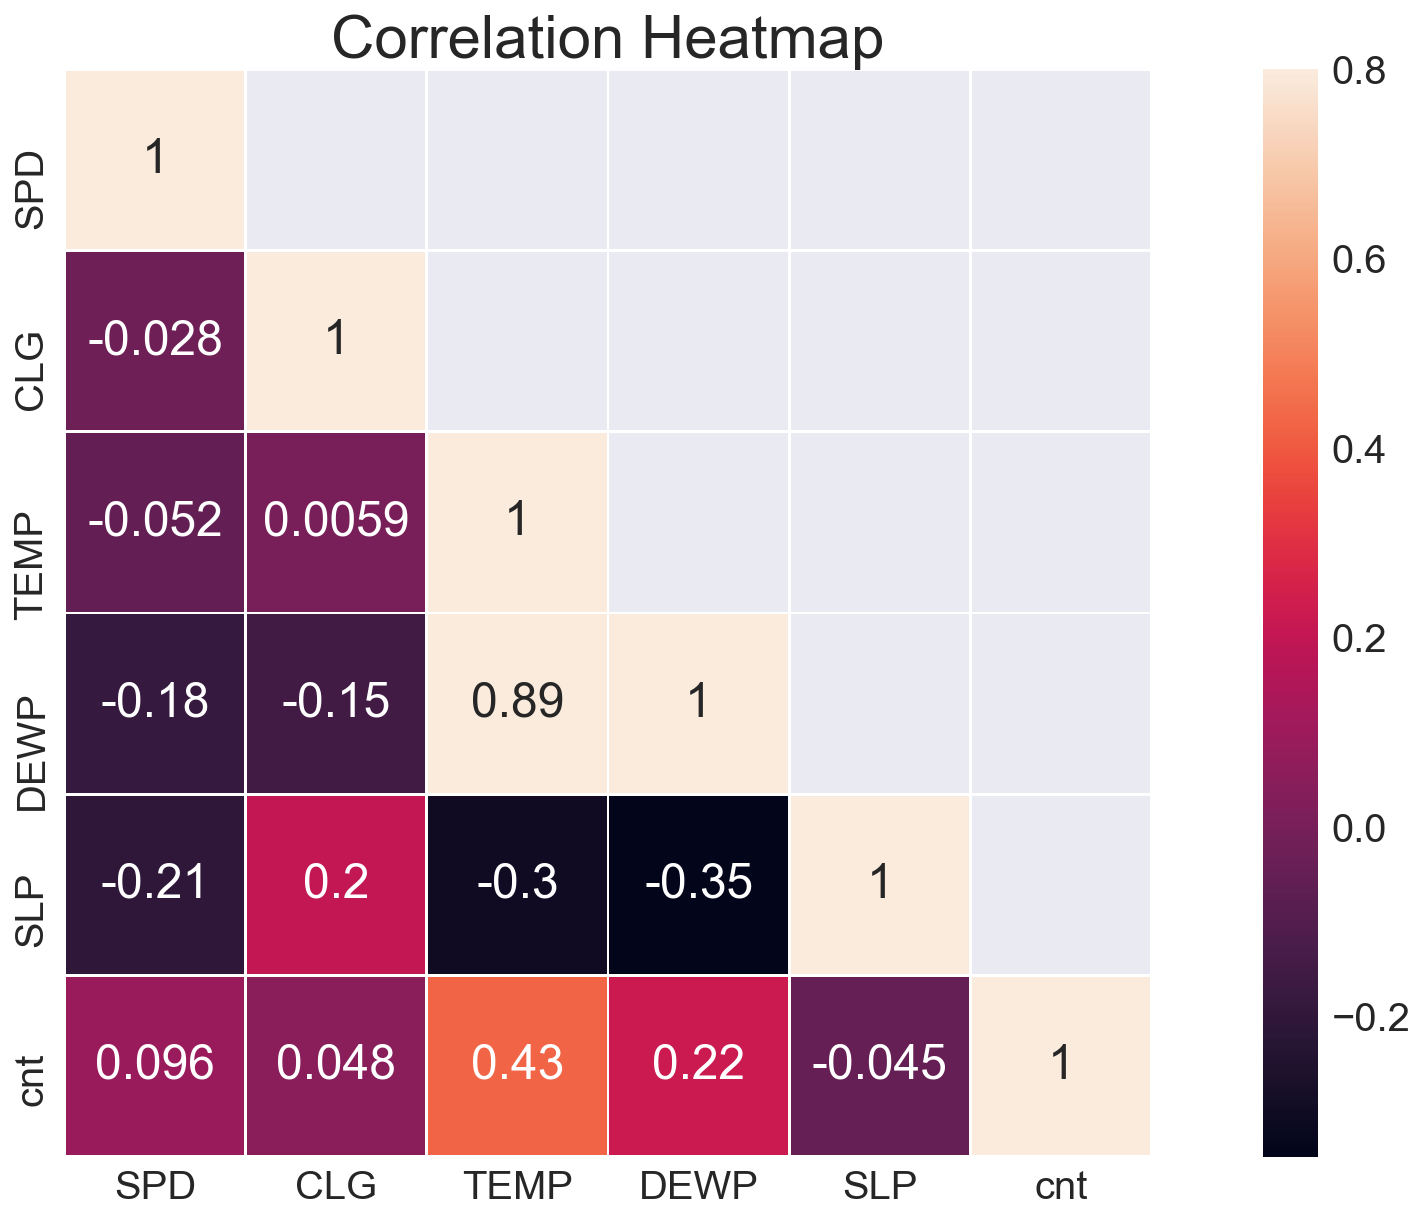

In [43]:
# Investigate the correlation between weather parameters.

corrMatt = rides[['SPD', 'CLG', 'TEMP', 'DEWP', 'SLP','cnt']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

sns.set(font_scale = 2)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True, linewidths=1)
ax.axes.set_title('Correlation Heatmap', fontsize = 30)

# Deep Learning
### A bit more data cleaning

In [44]:
df_combine['year'] = df_combine.year.apply(lambda x: 0 if x == 2016 else 1)

dummy_fields = ['quarter', 'month', 'hour', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(df_combine[each], prefix=each, drop_first=False)
    df_combine = pd.concat([df_combine, dummies], axis=1)

fields_to_drop = ['quarter', 'month', 'hour', 'weekday', 'dteday']
data = df_combine.drop(fields_to_drop, axis=1)
data.head()

,year,day,casual,registered,cnt,holiday,SPD,CLG,TEMP,DEWP,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,1,9.0,47.0,56.0,1,11.0,44.0,45.0,32.0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,12.0,93.0,105.0,1,8.0,46.0,44.0,32.0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,15.0,59.0,74.0,1,8.0,46.0,44.0,32.0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,5.0,27.0,32.0,1,8.0,220.0,42.0,32.0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,5.0,8.0,13.0,1,7.0,220.0,42.0,30.0,...,0,0,0,0,0,0,0,1,0,0


### Feature Scaling

In [45]:
quant_features = ['casual', 'registered', 'cnt', 'SPD', 'CLG', 'TEMP', 'DEWP', 'SLP']

# Perform feature scaling such that all features ranging between -0.5 and 0.5. 
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Data Splitting Into Training, Testing & Validation Sets

I save the data for the last month (December, 31 days) to use as a test set after training the network. I'll use this set to make predictions and compare them with the actual number of riders.

In [46]:
# Save data for approximately the last 31 days 
test_data = data[-31*24:]

# Remove the test data from the orginial data set 
data = data[:-31*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [47]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Network Building

I'll implement both the forward pass and backwards pass through the network and also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. 

In [48]:
model = Sequential()

model.add(Dense(20, input_dim=train_features.shape[1]))
model.add(Activation('sigmoid'))
model.add(Dense(1))

model.compile(loss='mse', optimizer = 'adam', metrics = ['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                1120      
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Set train, test and validation datasets
X_train = np.array(train_features)
y_train = np.array(train_targets['cnt'])
X_val = np.array(val_features)
y_val = np.array(val_targets['cnt'])
X_test = np.array(test_features)
y_test = np.array(test_targets['cnt'])

print(X_train.shape)
print(y_train.shape)

(15184, 55)
(15184,)


In [50]:
print(train_features.shape)

(15184, 55)


In [51]:
type(X_train.shape[1])

int

In [52]:
history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_val,y_val), batch_size=X_train.shape[1], verbose=2)


Train on 15184 samples, validate on 1440 samples
Epoch 1/100
 - 3s - loss: 0.8132 - mean_squared_error: 0.8132 - val_loss: 0.6778 - val_mean_squared_error: 0.6778
Epoch 2/100
 - 0s - loss: 0.4682 - mean_squared_error: 0.4682 - val_loss: 0.3927 - val_mean_squared_error: 0.3927
Epoch 3/100
 - 0s - loss: 0.3164 - mean_squared_error: 0.3164 - val_loss: 0.3099 - val_mean_squared_error: 0.3099
Epoch 4/100
 - 0s - loss: 0.2858 - mean_squared_error: 0.2858 - val_loss: 0.3083 - val_mean_squared_error: 0.3083
Epoch 5/100
 - 0s - loss: 0.2757 - mean_squared_error: 0.2757 - val_loss: 0.2815 - val_mean_squared_error: 0.2815
Epoch 6/100
 - 0s - loss: 0.2696 - mean_squared_error: 0.2696 - val_loss: 0.2790 - val_mean_squared_error: 0.2790
Epoch 7/100
 - 0s - loss: 0.2652 - mean_squared_error: 0.2652 - val_loss: 0.2762 - val_mean_squared_error: 0.2762
Epoch 8/100
 - 0s - loss: 0.2607 - mean_squared_error: 0.2607 - val_loss: 0.2698 - val_mean_squared_error: 0.2698
Epoch 9/100
 - 0s - loss: 0.2571 - mean

Epoch 72/100
 - 0s - loss: 0.0654 - mean_squared_error: 0.0654 - val_loss: 0.0660 - val_mean_squared_error: 0.0660
Epoch 73/100
 - 0s - loss: 0.0652 - mean_squared_error: 0.0652 - val_loss: 0.0726 - val_mean_squared_error: 0.0726
Epoch 74/100
 - 0s - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.0727 - val_mean_squared_error: 0.0727
Epoch 75/100
 - 0s - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0628 - val_mean_squared_error: 0.0628
Epoch 76/100
 - 0s - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0717 - val_mean_squared_error: 0.0717
Epoch 77/100
 - 0s - loss: 0.0637 - mean_squared_error: 0.0637 - val_loss: 0.0705 - val_mean_squared_error: 0.0705
Epoch 78/100
 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0710 - val_mean_squared_error: 0.0710
Epoch 79/100
 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0645 - val_mean_squared_error: 0.0645
Epoch 80/100
 - 0s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.061

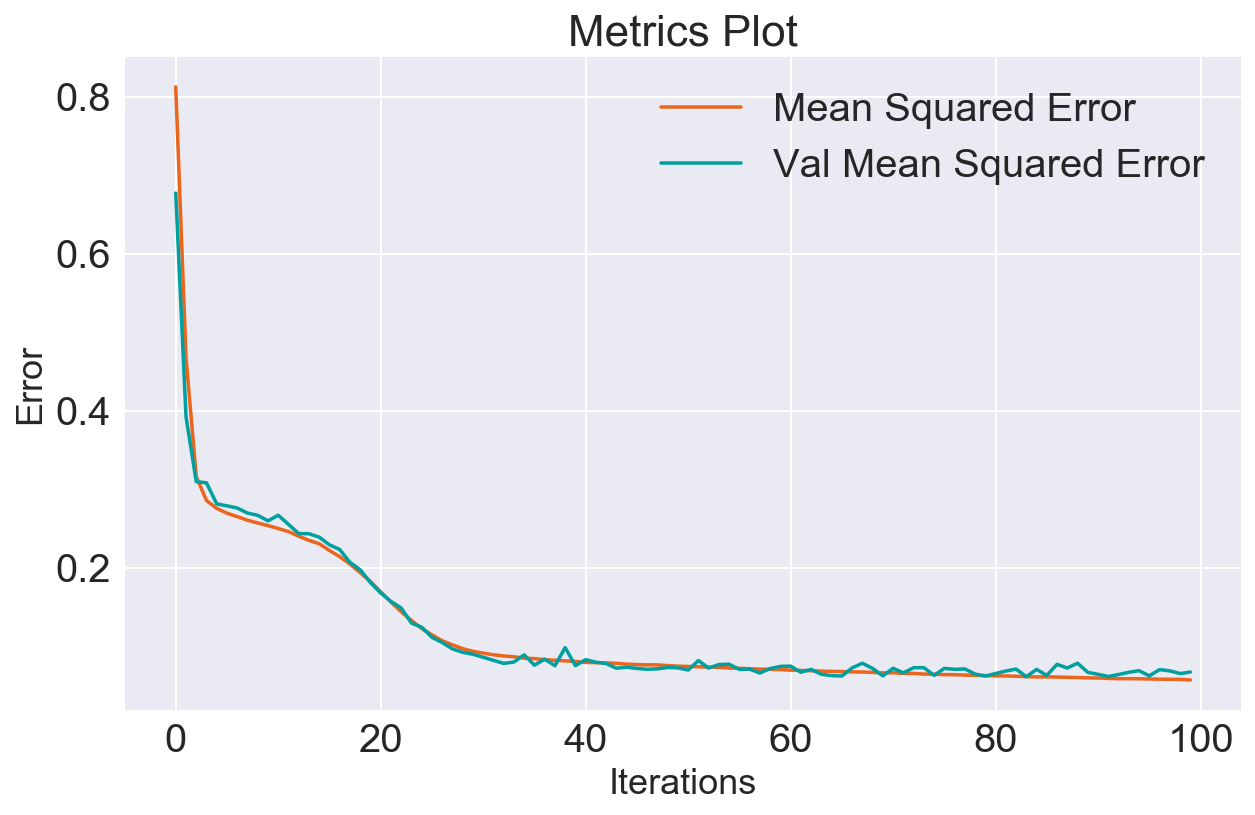

In [53]:
# plot metrics
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(history.history['mean_squared_error'], label='Mean Squared Error', color = '#EA651D')
plt.plot(history.history['val_mean_squared_error'], label='Val Mean Squared Error', color = '#00A0A0')
ax.legend()
plt.title('Metrics Plot', fontsize = 22)
plt.xlabel('Iterations', fontsize = 18)
plt.ylabel('Error', fontsize =18)
plt.show()

In [54]:
mean, std = scaled_features['cnt']
predictions = model.predict(X_test).T*std + mean
print(predictions[0].shape)

(744,)


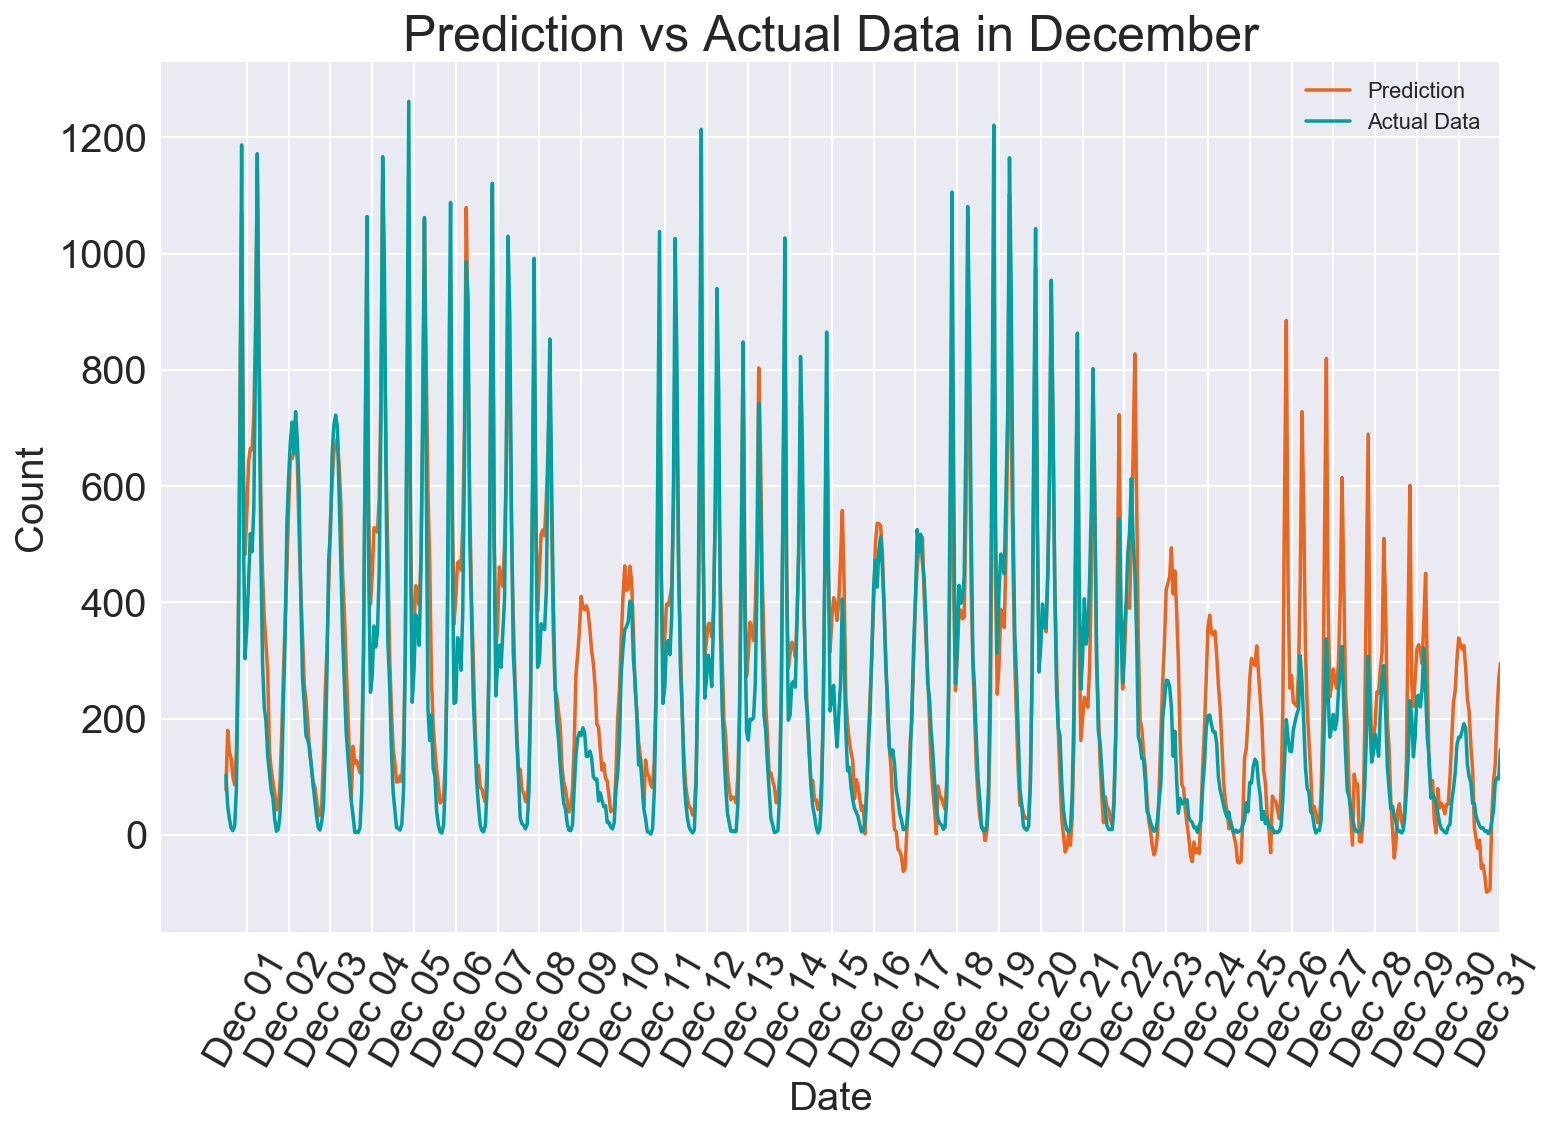

In [55]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.set(font_scale = 1.1)
ax.plot(predictions[0], label='Prediction', color = '#EA651D')
ax.plot((test_targets['cnt']*std + mean).values, label='Actual Data', color = '#00A0A0')
ax.set_xlim(right=len(predictions))
ax.legend()
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Prediction vs Actual Data in December', fontsize = 25)

dates = pd.to_datetime(df_combine.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=60)


In [56]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

test_loss = MSE(model.predict(X_test).T, test_targets['cnt'].values)
print(test_loss)

0.07540066287807065
